In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import binom_test 
import os

import seaborn as sns
sns.set(font_scale= 1.5)
sns.set_style('whitegrid') 

import sys
sys.path.append('/work-zfs/abattle4/heyuan/old_work_files/yuan/tools/python_lib/lib/python2.7/site-packages')

from matplotlib_venn import venn3, venn2

from statsmodels.stats.multitest import multipletests
sns.set(font_scale= 1.5)
sns.set_style('whitegrid')

from scipy.stats import ranksums


In [81]:
def read_in_WGS_GT(sample):
    WGS_dir = '/work-zfs/abattle4/heyuan/Variant_calling/benchmarking/datasets/GBR/Genotype'

    chromosome = 22
    WGS_fn = '%s/1k_genome_chr%d.genotypes.tsv' % (WGS_dir, chromosome)
    WGS_result = pd.read_csv(WGS_fn, comment = '$', sep='\t', nrows = 10)
    try:
        col_to_read = list(WGS_result.columns).index(sample)
    except:
        print('%s does not have genotype data' % sample)
        return 
    
    WGS_result = pd.DataFrame()

    for chromosome in range(1,23):
        WGS_fn = '%s/1k_genome_chr%d.genotypes.tsv' % (WGS_dir, chromosome)
        token = pd.read_csv(WGS_fn, 
                            comment = '$', 
                            sep='\t', 
                            usecols=[0,1,2,col_to_read])
        WGS_result = WGS_result.append(token)
        
    WGS_result = WGS_result.drop_duplicates()
        
    return WGS_result

In [106]:
def obtain_intersection_df(sample, minDP, WGS_result, restrict_to_SNP = True):
    
    WGS_result = WGS_result.copy()
    
    SNP_calling_dir = '/work-zfs/abattle4/heyuan/Variant_calling/benchmarking/datasets/GBR/ATAC_seq/alignment_bowtie'
        
    SNP_called_fn = '%s/Called_GT/%s_minDP_%d.genotypes.txt' % (SNP_calling_dir, sample, minDP)
    SNP_called = pd.read_csv(SNP_called_fn, comment="$", sep='\t', nrows = 10)
    try:
        col_to_read = np.where([sample in x for x in SNP_called.columns])[0][0]
    except:
        print('%s does not called genotpye' % sample)
        return
    
    SNP_called = pd.read_csv(SNP_called_fn, comment="$", sep='\t', usecols=[0, 1, 2, col_to_read])
    SNP_called.columns = list(SNP_called.columns[:3]) + ['%s_called' % sample]
    SNP_called['#CHROM'] = [int(x.replace('chr','')) for x in SNP_called['#CHROM']]
    
    # restrict to SNP
    if restrict_to_SNP:
        WGS_result = WGS_result.iloc[np.where([len(x) == 1 for x in WGS_result['REF']])[0]]
        WGS_result = WGS_result.iloc[np.where([len(x.split('/')[0]) == 1 for x in WGS_result[sample]])[0]]
        WGS_result = WGS_result.iloc[np.where([len(x.split('/')[1]) == 1 for x in WGS_result[sample]])[0]]
        
        SNP_called = SNP_called.iloc[np.where([len(x.split('/')[1]) == 1 for x in SNP_called['%s_called' % sample]])[0]]
        SNP_called = SNP_called.iloc[np.where([len(x.split('/')[1]) == 1 for x in SNP_called['%s_called' % sample]])[0]]
    
    # variants with some read
    intersection_SNPs = WGS_result.merge(SNP_called, on=['#CHROM', 'POS'])
    
    # match for the HT order
    intersection_SNPs['%s_makeup' % sample] = ['/'.join(x.split('/')[::-1]) for x in intersection_SNPs[sample]]
    
    HT = np.where(intersection_SNPs[sample] != intersection_SNPs['%s_makeup' % sample])[0]
    match_idx = np.where(intersection_SNPs['%s_called' % sample] == intersection_SNPs['%s_makeup' % sample])[0]
    need_to_flip = np.intersect1d(HT, match_idx)
    intersection_SNPs.loc[need_to_flip,sample] = intersection_SNPs.loc[need_to_flip,'%s_makeup' % sample]

    true_hits = np.sum(intersection_SNPs[sample] == intersection_SNPs['%s_called' % sample])

    print('For %s:' % sample)
    print("In total, WGS called %d SNVs" % len(WGS_result))
    print("Variant caller called %d SNVs" % len(SNP_called))
    
    print("Variant called called %d (%.3f) SNVs found in WGS" % (len(intersection_SNPs), 
                                                                 len(intersection_SNPs)/len(SNP_called)))

    print("   %d (%.3f) are correct" % (true_hits, true_hits / len(SNP_called)))
    
    
    return intersection_SNPs

In [107]:
def obtain_confusion_matrix(intersection_df):
    intersection_df['Alt1'] = [x.split('/')[0] for x in intersection_df[sample]]
    intersection_df['Alt2'] = [x.split('/')[1] for x in intersection_df[sample]]
    intersection_df['MT']= (intersection_df['Alt1'] != intersection_df['REF_x']) & (intersection_df['Alt2'] != intersection_df['REF_x'])
    intersection_df['HT'] = intersection_df['Alt1'] != intersection_df['Alt2']

    intersection_df['called_Alt1'] = [x.split('/')[0] for x in intersection_df['%s_called' % sample]]
    intersection_df['called_Alt2'] = [x.split('/')[1] for x in intersection_df['%s_called' % sample]]
    intersection_df['called_MT']= (intersection_df['called_Alt1'] != intersection_df['REF_x']) & (intersection_df['called_Alt2'] != intersection_df['REF_x'])
    intersection_df['called_HT'] = intersection_df['called_Alt1'] != intersection_df['called_Alt2']

    ## Real Genotype

    # Heterozygous - AB
    ab = intersection_df[intersection_df['HT']]

    # called genotypes
    ab_called_ab = np.sum(ab['called_HT'])
    ab_called_aa = np.sum((~ab['called_HT']) & (~ab['called_MT']))
    ab_called_bb = np.sum((~ab['called_HT']) & (ab['called_MT']))

    assert (ab_called_ab + ab_called_aa + ab_called_bb == len(ab))

    # Homogenous wildtype
    aa = intersection_df[(~intersection_df['HT']) & (~intersection_df['MT'])]

    # called genotypes
    aa_called_ab = np.sum(aa['called_HT'])
    aa_called_aa = np.sum((~aa['called_HT']) & (~aa['called_MT']))
    aa_called_bb = np.sum((~aa['called_HT']) & (aa['called_MT']))
    assert (aa_called_ab + aa_called_aa + aa_called_bb == len(aa))

    # Homogenous mutation
    bb = intersection_df[(~intersection_df['HT']) & (intersection_df['MT'])]

    # called genotype
    bb_called_ab = np.sum(bb['called_HT'])
    bb_called_aa = np.sum((~bb['called_HT']) & (~bb['called_MT']))
    bb_called_bb = np.sum((~bb['called_HT']) & (bb['called_MT']))
    assert (bb_called_ab + bb_called_aa + bb_called_bb == len(bb))

    confusion_matrix = pd.DataFrame([[aa_called_aa, aa_called_ab, aa_called_bb], 
                                     [ab_called_aa, ab_called_ab, ab_called_bb],
                                     [bb_called_aa, bb_called_ab, bb_called_bb]])

    confusion_matrix.columns = ['call_AA', 'called_AB', 'called_BB']
    confusion_matrix.index = ['true_AA', 'true_AB', 'true_BB']
    
    return confusion_matrix

In [126]:
sample = 'HG00108'

In [129]:
# variant calling information
variant_calling_dir = '/work-zfs/abattle4/heyuan/Variant_calling/benchmarking/datasets/GBR/ATAC_seq/alignment_bowtie'

info_df = pd.read_csv('%s/%s-RG-dedup-hapcal.filtered.variants.recode.INFO.txt' % (variant_calling_dir, sample),sep='\t', header = None)
info_df.columns=['#CHROM', 'POS', 'DP', 'PL']
info_df['#CHROM'] = [int(x.replace('chr', '')) for x in info_df['#CHROM']]

info_df_unamb = info_df[['0,0' not in x for x in info_df['PL']]]


In [ ]:
WGS_df = read_in_WGS_GT(sample)

In [130]:
if 1:
    for minDP in range(3,11):
        sample_df = obtain_intersection_df(sample, minDP = minDP, WGS_result=WGS_df)
        if sample_df is not None:
            confusion_matrix = obtain_confusion_matrix(sample_df)
            confusion_matrix.to_csv('confusion_matrices/%s_bowtie_GATK_DPmin%d_SNPs.txt' % (sample, minDP), sep='\t')
            
            # remove ambiguous calls
            sample_df = sample_df.merge(info_df_unamb, on = ['#CHROM', 'POS'])
            confusion_matrix = obtain_confusion_matrix(sample_df)
            confusion_matrix.to_csv('confusion_matrices/%s_bowtie_GATK_DPmin%d_SNPs_noAmbig.txt' % (sample, minDP), sep='\t')
        else:
            continue

For HG00108:
In total, WGS called 6057592 SNVs
Variant caller called 568444 SNVs
Variant called called 542321 (0.954) SNVs found in WGS
   444431 (0.782) are correct
For HG00108:
In total, WGS called 6057592 SNVs
Variant caller called 281088 SNVs
Variant called called 268805 (0.956) SNVs found in WGS
   237474 (0.845) are correct
For HG00108:
In total, WGS called 6057592 SNVs
Variant caller called 161805 SNVs
Variant called called 154765 (0.956) SNVs found in WGS
   143404 (0.886) are correct
For HG00108:
In total, WGS called 6057592 SNVs
Variant caller called 110287 SNVs
Variant called called 105575 (0.957) SNVs found in WGS
   100495 (0.911) are correct
For HG00108:
In total, WGS called 6057592 SNVs
Variant caller called 85083 SNVs
Variant called called 81512 (0.958) SNVs found in WGS
   78660 (0.925) are correct
For HG00108:
In total, WGS called 6057592 SNVs
Variant caller called 70937 SNVs
Variant called called 67957 (0.958) SNVs found in WGS
   66087 (0.932) are correct
For HG0010

In [114]:
mismatch = sample_df[sample_df[sample] != sample_df['%s_called' % sample]]
mismatch = mismatch.merge(info_df, on=['#CHROM', 'POS'])

match = sample_df[sample_df[sample] == sample_df['%s_called' % sample]]
match = match.merge(info_df, on=['#CHROM', 'POS'])

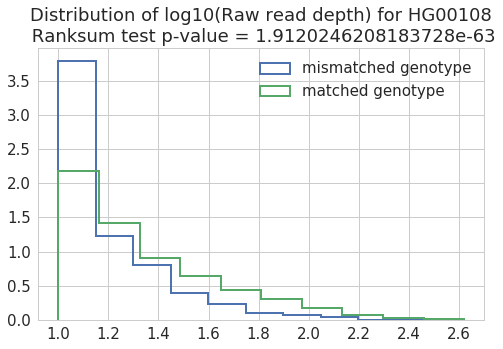

In [115]:
x = [np.log10(x) for x in np.array(mismatch['DP'])]
y = [np.log10(x) for x in np.array(match['DP'])]


plt.figure(figsize = (8,5))
plt.hist(np.array(x), density = True, label = 'mismatched genotype', 
         histtype = 'step', linewidth = 2)
plt.hist(np.array(y), density = True, label = 'matched genotype', 
         histtype = 'step', linewidth = 2)
plt.title('Distribution of log10(Raw read depth) for %s\n Ranksum test p-value = %s' % (sample, 
                                                                                        ranksums(np.log10(x), np.log10(y))[1]))
plt.legend()
plt.show()

In [120]:
np.sum(['0,0' in x for x in mismatch['PL']]) / len(mismatch)

0.38503649635036497

In [121]:
np.sum(['0,0' in x for x in match['PL']]) / len(match)

0.05845895164916808